в этом блокноте: 
- обучим модель бинарной классификации, основанную на линейной регрессии
- проверим её качество на отложенной выборке по знпчению площади под ROC-кривой
- сохраним обученную модель в директорию на HDFS  

Датасет по определению типа вина - белое или красное. Взят [отсюда с Kaggle](https://www.kaggle.com/datasets/subhajournal/wine-quality-data-combined)

вот такие у нас есть столбцы:
- ```fixed acidity``` - фиксированная кислотность
- ```volatile acidity``` - летучая кислотность
- ```citric acid``` - лимонная кислота
- ```residual sugar``` - остаточный сахар
- ```chlorides``` - хлориды
- ```free sulfur dioxide``` - свободный диоксид серы
- ```total sulfur dioxide``` - общий диоксил серы
- ```density``` - плотность
- ```pH``` - pH
- ```sulphates``` - сульфаты
- ```alcohol``` - алкоголь
- ```quality``` - качество
- ```Type``` - тип (целевая переменная)

_____

импортируем все библиотеки и модули, что нам понадобятся:

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 

Открываем сессию, скачиваем датасет и смотрим на него:

In [2]:
spark = SparkSession.builder \
    .appName('lesson7') \
    .config('spark.executor.instances', 4) \
    .getOrCreate()

23/08/23 19:45:28 WARN Utils: Your hostname, mysha-Inspiron-11-3147 resolves to a loopback address: 127.0.1.1; using 192.168.1.75 instead (on interface wlp1s0)


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars

In [3]:
df = spark.read.csv('/mysha/dz7/WineQuality.csv', header=True, inferSchema=True).drop('_c0')
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- Type: string (nullable = true)



In [4]:
desc = df.describe()
for col in desc.columns:
    if col not in ['summary', 'Type']:
        desc = desc.withColumn(col, F.round(col, 2))
desc.show()

+-------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+-------+---------+-------+-------+----------+
|summary|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|     pH|sulphates|alcohol|quality|      Type|
+-------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+-------+---------+-------+-------+----------+
|  count|      32485.0|         32485.0|    32485.0|       32485.0|  32485.0|            32485.0|             32485.0|32485.0|32485.0|  32485.0|32485.0|32485.0|     32485|
|   mean|         7.21|            0.34|       0.32|          5.44|     0.06|              30.46|              115.66|   0.99|   3.22|     0.53|  10.48|   5.81|      null|
| stddev|         1.31|            0.16|       0.15|           4.8|     0.03|              17.61|               56.46|    0.0|   0.16|     0

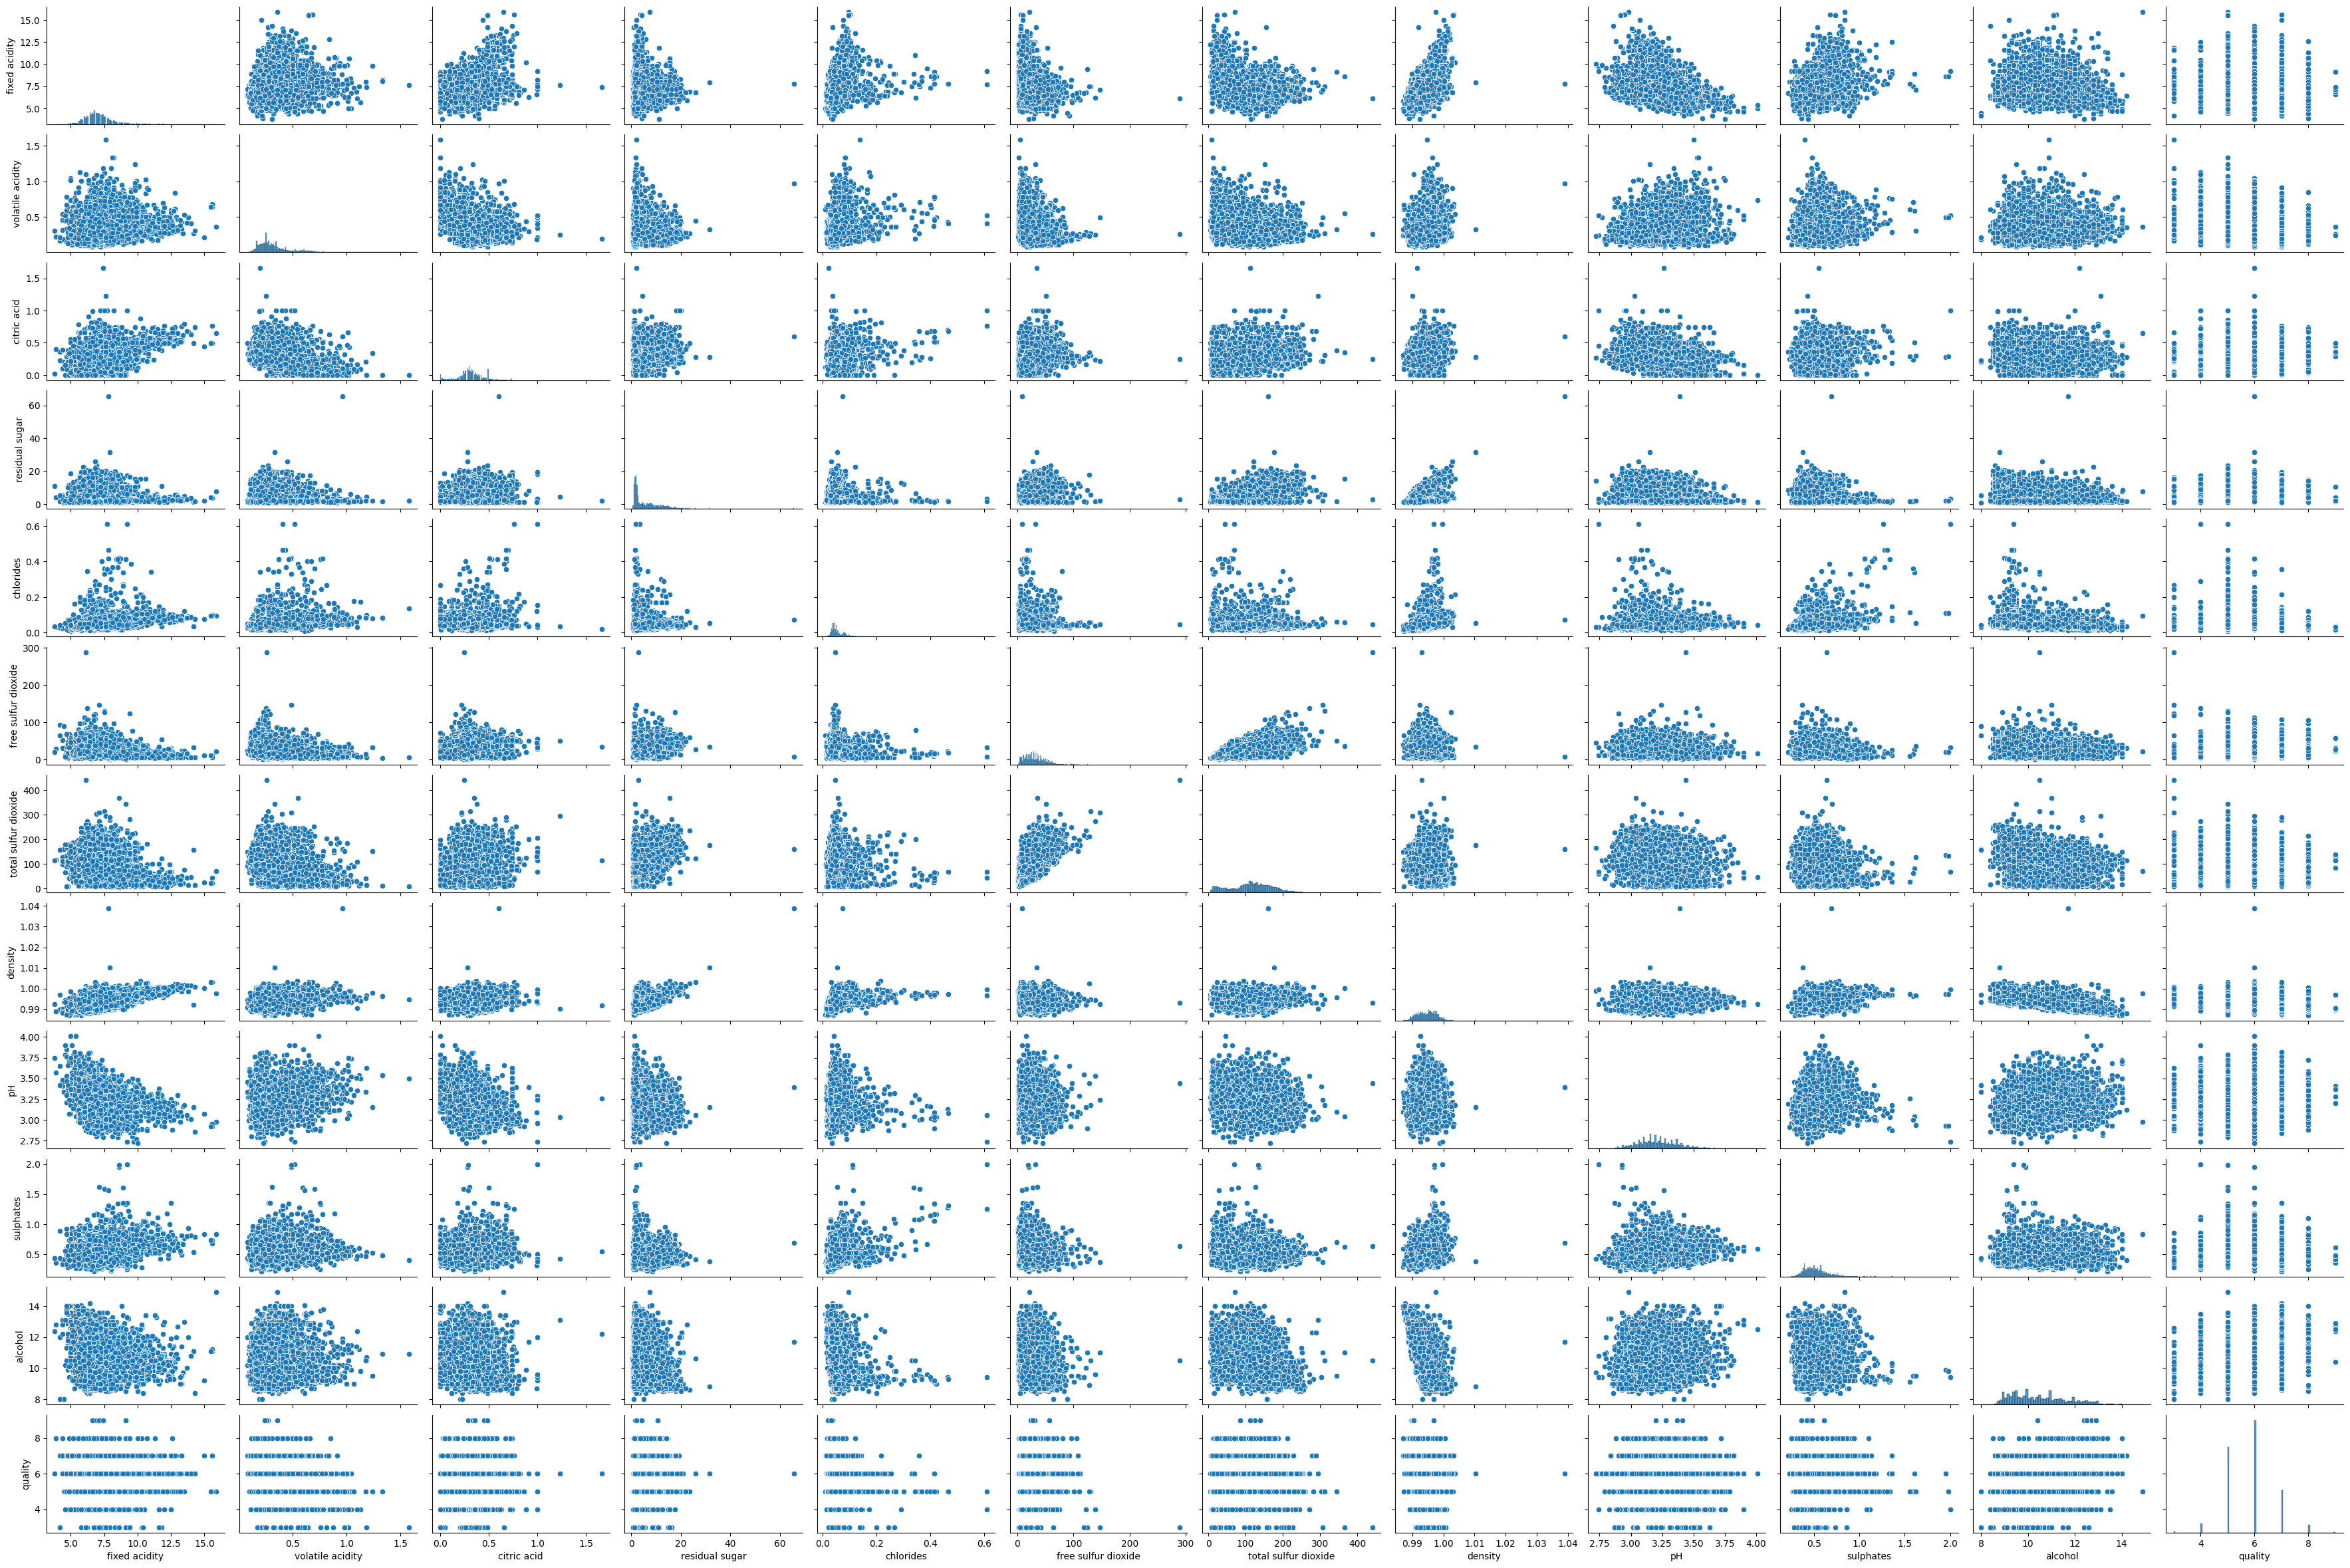

In [5]:
numericCols = df.drop('Type').columns

numeric_data = df.select(numericCols).toPandas()
sns.pairplot(numeric_data, diag_kind='hist', height=2, aspect=1.5);

распределение значений в таргете:

In [6]:
df.groupby('Type').count().show()

+----------+-----+
|      Type|count|
+----------+-----+
|White Wine|24453|
|  Red Wine| 8032|
+----------+-----+



все признаки, кроме таргета, числовые, пропусков нет. Это немного упрощает задачу по их трансформации, не придётся делать OHE-кодирование

_____

подготовим данные для модели и разделим датасет на тренировочную и тестовую выборки:

In [7]:
# преобразуем таргет в числовые метки
label_stringIdx = StringIndexer(inputCol='Type', outputCol='label')
# объединяем все числовые признаки в один векторный столбец
assembler = VectorAssembler(inputCols=numericCols, outputCol='features')
# ну и делим датасет
train, test = df.randomSplit([0.7, 0.3], seed=42)

Проверим контрольно, в каком соотношении таргет распределился после разбиения на train и test:

In [8]:
train.groupby('Type').count().show()

+----------+-----+
|      Type|count|
+----------+-----+
|White Wine|17189|
|  Red Wine| 5635|
+----------+-----+



In [9]:
test.groupby('Type').count().show()

+----------+-----+
|      Type|count|
+----------+-----+
|White Wine| 7264|
|  Red Wine| 2397|
+----------+-----+



модель - лог.регрессия, добавим её и соберём все шаги для пайплайна:

In [10]:
lr = LogisticRegression(maxIter=10)

собираем пайплайн, трансформируем тренировочную выборку и предсказываем на тренировочной и на тестовой:

In [11]:
pipeline = Pipeline(stages=[label_stringIdx, assembler, lr])

# обучаемся на тренировочной:
lrModel = pipeline.fit(train)
# применяем обучение к тренировочной:
train_predictions = lrModel.transform(train)
# и к тестовой:
test_predictions = lrModel.transform(test)

Посчитаем areaUnderROC на тренировочной и тестовой выборках:

In [12]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

train_auc_roc = evaluator.evaluate(train_predictions)
test_auc_roc = evaluator.evaluate(test_predictions)

print(f'Train AUC-ROC: {train_auc_roc}\nTest AUC-ROC:{test_auc_roc}')

Train AUC-ROC: 0.9967542282540415
Test AUC-ROC:0.9967734252525664


метрика на тесте хорошая, модель справилась $\Rightarrow$ сохраняем её в директорию на HDFS:

In [13]:
try:
    lrModel.write().overwrite().save('/mysha/dz7/wine_lr_Model')
    print('успех!')
except:
    print('что-то пошло не так')

успех!
